# End-To-End Training Example of RNN for rain estimation and detection using PyNNCML
This notebook presents an end-to-end example of training a Recurrent Neural Network (RNN) based rain estimation neural network [1] on the openMRG dataset.
This tutorial is built using the PyNNCML software package, which provides both tools to simplify the training process of deep learning models for CMLs.
We start with obtaining a subset of the OpenMRG dataset and splitting it into training and validation datasets.
Afterward, we construct the One Step Network from [1], followed by the training loop.
Finally, we analyze the model performance in terms of RMSE and Bias.


Notebook structure
1. Imports and Installation of PyNNCML
2. Hyperparameter settings
3. Build Dataset
4. Build Neural Network
5. Training Loop
6. Neural Network Analysis


[Run this notebook in colab](https://colab.research.google.com/github/haihabi/PyNNcml/blob/master/examples/training_rnn.ipynb)

To run this notebook on Colab using GPU, please do the following:
Runtime -> Change runtime type -> Select GPU -> Save


In [1]:
import sys
import os

if os.path.exists('../../pynncml'):
    print("Import PyNNCML From Code")
    sys.path.append('../../')  # This line is need to import pynncml
else:
    print("Install PyNNCML From pip")
    !pip install pynncml

import pynncml as pnc
import torch
import math
from matplotlib import pyplot as plt
import wandb
import random
import numpy as np
from tqdm import tqdm

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)



Import PyNNCML From Code


In [2]:
batch_size = 128
window_size = 32
lr = 1e-4

# xy_min = [1.29e6, 0.565e6]  # Link Region
# xy_max = [1.34e6, 0.5875e6]

xy_min = None
xy_max = None
time_slice = slice("2015-06-01", "2015-06-14")  # Time Interval
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Building Training and Validation datasets

File already exists at desired location ./data/OpenMRG.zip
Not downloading!


100%|██████████| 728/728 [00:14<00:00, 50.75it/s] 


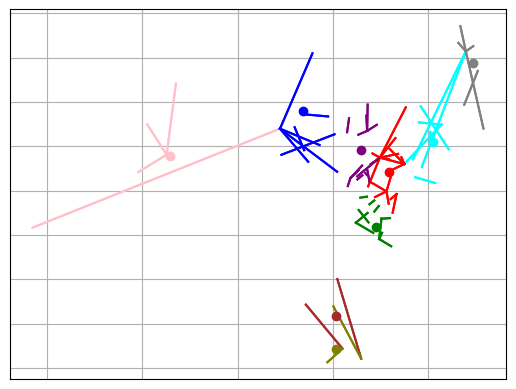

In [3]:
dataset_base = pnc.datasets.loader_open_mrg_dataset(xy_min=xy_min, xy_max=xy_max, time_slice=time_slice)
dataset = pnc.datasets.linkdataset2subsequent(dataset_base)
dataset_base.link_set.plot_links()
plt.grid()
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
data_loader_all = torch.utils.data.DataLoader(dataset_base, batch_size)
data_loader = torch.utils.data.DataLoader(training_dataset, batch_size)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size)


# Prior

# Neural Network

# Loss


In [5]:
loss_function = torch.nn.MSELoss()

# Training Loop

In [6]:
from examples.rain_score.score.ema import ModelEma
from examples.rain_score.conformer.conditional_encoder import RainScoreConformer
from examples.rain_score.conformer.encoder import RainConformer

model = RainConformer().to(device)
ema = ModelEma(model)
lr = 1e-5
warmup_epochs = 50
n_epochs = 4000
div_factor = 100
wandb.init(project="rain_former")
opt = torch.optim.Adam(model.parameters(), lr=lr)
scheduler_cosin = torch.optim.lr_scheduler.CosineAnnealingLR(opt, n_epochs - warmup_epochs,
                                                             eta_min=lr / div_factor)
scheduler_warmup = torch.optim.lr_scheduler.LinearLR(opt, 1 / div_factor, 1, total_iters=warmup_epochs)
scheduler = torch.optim.lr_scheduler.SequentialLR(opt, [scheduler_warmup, scheduler_cosin], [warmup_epochs])

total_step = n_epochs * len(data_loader)
ra = pnc.analysis.ResultsAccumulator()
am = pnc.analysis.AverageMetric()
model.train()
print("Start Training")
pbar = tqdm(range(n_epochs), desc='description')
for epoch in pbar:
    am.clear()

    for rain_rate, data, metadata in data_loader:
        opt.zero_grad()
        model.train()
        data = data.to(device)
        metadata = metadata.to(device)
        rain_rate = rain_rate.reshape([-1, 1]).float().to(device)

        rain_hat = model(data, metadata.to(device))
        loss = loss_function(rain_hat.squeeze(dim=-1), rain_rate)
        loss.backward()
        ema.update(model)
        opt.step()

        am.add_results(loss=loss.item())
    scheduler.step()

    loss_avg = am.get_results("loss")
    pbar.set_description(f"Loss Value {loss_avg}")
    res = {"loss": am.get_results("loss")}
    wandb.log(res)
    ra.add_results(**res)
wandb.finish()

wandb: Currently logged in as: hvh. Use `wandb login --relogin` to force relogin


Start Training


description:   0%|          | 0/4000 [00:00<?, ?it/s]C:\Users\haiha\.conda\envs\Research\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\haiha\.conda\envs\Research\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([56, 1])) that is different to the input size (torch.Size([56])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Loss Value 1.64412024974823:   1%|          | 49/4000 [01:00<1:19:55,  1.21s/it]  C:\Users\haiha\.conda\envs\Research\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was

loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,1.63025


In [7]:
mse = 0
bias = 0
count = 0
for rain_rate, data, metadata in val_loader:
    data = data.to(device)
    metadata = metadata.to(device)
    rain_rate = rain_rate.reshape([-1, 1]).float().to(device)
    rain_hat = model(data, metadata)
    delta = rain_rate - rain_hat
    mse += torch.mean(delta ** 2).item()
    bias += torch.mean(delta)
    count += 1
print(math.sqrt(mse / count), bias / count)

1.0704613668628498 0.019381228142311004


-------------------------------------------------- Results Summery --------------------------------------------------
+--------------+-------------+------------+-----------+
|    Metric    |    0<r<4    |   4<r<8    |  8<r<inf  |
+--------------+-------------+------------+-----------+
|     RMSE     |  0.94458026 | 3.9791288  |  9.792482 |
|     BIAS     |  -0.1669704 | 3.8634274  |  9.533251 |
|    NRMSE     |  0.8827449  | 0.77994716 |  0.908795 |
|    NBIAS     | -0.15603997 | 0.7572686  | 0.8847369 |
| Total Metric |    Value    |     -      |     -     |
|     RMSE     |  1.3317567  |     -      |     -     |
|     BIAS     | 0.023969883 |     -      |     -     |
|    NRMSE     |  1.0560629  |     -      |     -     |
|    NBIAS     | 0.019007755 |     -      |     -     |
+--------------+-------------+------------+-----------+
------------------------------------------------------------------------------------------------------------------------------------------------------


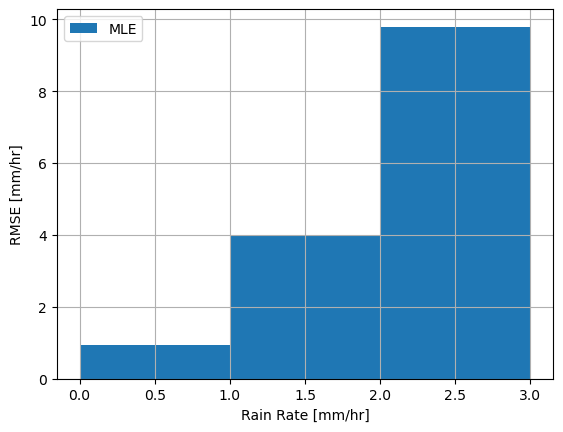

In [16]:
print(math.sqrt(mse / count), bias / count)